# User Intent Classification

## 🔍 Why Use Intent Classification in RAG Systems

User intent classification plays a key role in improving the quality of **Retrieval-Augmented Generation (RAG)** systems. It helps ensure that the right documents are retrieved before passing them to a language model.

### ✅ Benefits

- **🎯 Improves Retrieval Relevance**  
  Filters documents based on intent, reducing irrelevant chunks retrieved.

- **🔍 Enables Intent-Based Indexing**  
  Documents are organized by intent category (e.g., `apply_visa`, `track_application`), making search more efficient.

- **🧠 Builds Better Prompts for Generation**  
  Structured prompts based on intent guide the LLM to generate focused answers.

- **🔄 Combines with Semantic Search**  
  Intent narrows down candidate documents before applying vector similarity.

- **📊 Enables Analytics & Personalization**  
  Intent tracking helps tailor responses and refine knowledge coverage.

### 📁 Example Use Case

For a **Japan visa assistance chatbot**, intent classification helps identify if the user wants to:

- `apply_visa`
- `schedule_appointment`
- `check_requirements`
- `track_application`

Once classified, only documents relevant to that intent are passed to the retriever.

---

## 🧪 Example: TF-IDF + Logistic Regression Classifier

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd

# 📝 Sample dataset
data = {
    "text": [
        "Paano mag-apply ng Japan visa?",
        "Ano ang requirements sa tourist visa?",
        "Ilang araw ang processing ng application?",
        "Saan ang Japan embassy?",
        "Paano ko i-track ang application ko?"
    ],
    "intent": [
        "apply_visa",
        "check_requirements",
        "visa_processing_time",
        "embassy_location",
        "track_application"
    ]
}

df = pd.DataFrame(data)

# 🧹 Clean and vectorize
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['intent']

# 🤖 Train classifier
model = LogisticRegression()
model.fit(X, y)

# 🔍 Predict a new query
new_query = "Paano ko malalaman kung approved na?"
new_vec = vectorizer.transform([new_query])
predicted_intent = model.predict(new_vec)[0]

print(f"🔮 Predicted intent: {predicted_intent}")


## Training

### Dataset

In [148]:
DATASET_URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR1hUlRhTJQgNzSbTyRtDNh1mCrbfy0iUm6oiHK7oHb_iQQ5t7XCB_xyUCwoZ2fdg/pub?output=xlsx'
SHEET_NAME = 'Intent Classification Dataset'

In [149]:
import pandas as pd

# Load the CSV file
df = pd.read_excel(DATASET_URL, sheet_name=SHEET_NAME)


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637 entries, 0 to 1636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   1637 non-null   object
 1   intent  1637 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB


In [151]:
df['intent'].value_counts()

intent
general_application_guidelines_japan_visa    99
tourist_visa_general                         94
visa_spouse_child_philippines                92
transit_visa_japan                           92
visa_for_business_or_conference              92
housekeeper_diplomat_visa                    92
visa_for_visiting_relatives                  91
visa_us_military_visit                       91
multiple_entry_financial_capacity            91
filipino_parent_jfc_visa                     91
multiple_entry_business_cultural             91
visa_for_visiting_friends                    90
multiple_entry_frequent_traveler             90
nikkei_jin_visa_requirements                 90
student_visa_japan                           88
dependent_visa_japan                         88
official_purpose_visa                        88
work_visa_japan                              87
Name: count, dtype: int64

### Preprocessing

In [152]:
import stopwordsiso as stopwords

tagalog_stopwords = stopwords.stopwords('tl')

In [153]:
additional_tagalog_stopwords = [
    'po',
    'pong'
    'ba',
    'lang',
    'bang'
]
for tl_stopword in additional_tagalog_stopwords:
    tagalog_stopwords.add(tl_stopword)

In [196]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

# 🔧 One-time setup (only the first time)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(tagalog_stopwords)


# 🧠 Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove special characters, numbers, punctuations (keep letters and space)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Tokenize
    tokens = nltk.word_tokenize(text)

    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 7. Join back to string
    return ' '.join(tokens)



class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # load your model or API key
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # return embedding vectors
        return [clean_text(text) for text in X]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [197]:
preprocessor = Preprocessor()
preprocessor.transform(df['query'])

['ba tourist visa magbabakasyon japan',
 'requirement tourist visa papuntang japan',
 'tourist visa ba pupunta mamasyal',
 'bayad ba pagapply tourist visa japan',
 'gaano katagal puwedeng manatili japan gamit tourist visa',
 'magapply tourist visa papuntang japan',
 'pwede ba magapply tourist visa first time traveler',
 'pong dokumento kailangang ipasa tourist visa',
 'tourist visa ba tawag sightseeing japan plano',
 'edad limit ba tourist visa japan',
 'itinerary requirement tourist visa application',
 'required ba travel insurance tourist visa',
 'handwritten form tourist visa tatanggapin ba',
 'ba hotel booking agad tourist visa',
 'pwede group application tourist visa',
 'student anong requirement tourist visa',
 'ba bank certificate tourist visa sponsor',
 'ba nbi clearance tourist visa',
 'pwede multiple entry tourist visa',
 'tourist visa ba kasama anak bakasyon',
 'magapply business visa papuntang japan',
 'ba invitation letter conference visa japan',
 'specific visa ba busines

### Split the dataset (Stratified)

In [198]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['query'], df['intent'], test_size=0.3, stratify=df['intent'], random_state=42)

### Option 1: TF-IDF + Logistic Regression Pipeline

In [199]:
models = []

In [200]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_pipeline = Pipeline([
    ('preprocess', Preprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

In [201]:
X_train

1005    May interview po ba sa Japan Embassy for multi...
227     May category po ba ng work visa para sa engine...
431      Pwede po ba mag-apply ulit kahit na-deny before?
691     Kaibigan ko po ang gagastos sa lahat, anong vi...
1491    Kailangan ba ng birth certificate para sa Nikk...
                              ...                        
748     Gusto ko lang dumalaw sa military base ng US s...
196     Sino ang pwedeng mag-apply ng multiple entry v...
209     Is there an interview for the student visa in ...
166     May special multiple entry visa ba para sa mga...
1609    Pwede po ba akong magsubmit ng handwritten fam...
Name: query, Length: 1145, dtype: object

In [202]:
tfidf_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('vectorizer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [159]:
models.append(tfidf_pipeline)

### Option 2: Embeddings + Logistic Regression Pipeline

In [160]:
from sentence_transformers import SentenceTransformer
import numpy as np


class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='intfloat/multilingual-e5-base'):
        # Load a multilingual embedding model from HuggingFace Model Hub
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(self.model.encode(X, convert_to_numpy=True))


embeddings_pipeline = Pipeline([
    ('preprocess', Preprocessor()),
    ('embedder', EmbeddingTransformer()),
    ('classifier', LogisticRegression())
])

In [161]:
models.append(embeddings_pipeline)

### Train the model

In [162]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'classifier__C': uniform(0.1, 10),
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

random_search_results = []
for model in models:
    grid = RandomizedSearchCV(model, param_dist, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1, n_iter=3)
    grid.fit(X_train, y_train)
    random_search_results.append(grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Python(20282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(20283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(20284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/krimssmirk/Desktop/thesis/rag/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Python(20991) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(20992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usin

### Evaluation

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


def evaluate(models, X, y):
    # Dummy model predictions
    models = {
        'TF-IDF + Logistic': models[0].predict(X),
        'SBERT + Logistic': models[1].predict(X)
    }

    metrics = ['precision', 'recall', 'f1-score']
    labels = sorted(list(set(y_test)))  # class labels

    # 📊 Store results
    all_reports = []

    for model_name, y_pred in models.items():
        report = classification_report(y, y_pred, output_dict=True)
        df = pd.DataFrame(report).transpose()
        df = df.loc[labels, metrics]  # Only class rows
        df['model'] = model_name
        df['class'] = df.index
        all_reports.append(df)

    # 🧩 Combine all reports into one DataFrame
    combined_df = pd.concat(all_reports)
    
    def plot_results(combined_df, metric):
        # Plot
        g = sns.catplot(
            data=combined_df,
            kind='bar',
            x='class',
            y=metric,
            hue='model',
            height=6,
            aspect=2
        )

        # Access the underlying axes
        ax = g.axes[0][0]

        # Add baseline at 85%
        ax.axhline(0.85, color='red', linestyle='--', linewidth=1.5, label='Baseline 85%')

        # Title and labels
        ax.set_title(f'{metric} per Class by Model')
        ax.set_ylabel(metric)
        ax.set_xlabel('User Intent')
        ax.set_ylim(0, 1)
        ax.grid(axis='y')
        plt.xticks(rotation=90)

        # Optional: Add legend entry for the baseline
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, title='Model', loc='upper right')

        # Show plot
        # plt.tight_layout()
        plt.show()
    
    for metric in metrics:
        plot_results(combined_df, metric)

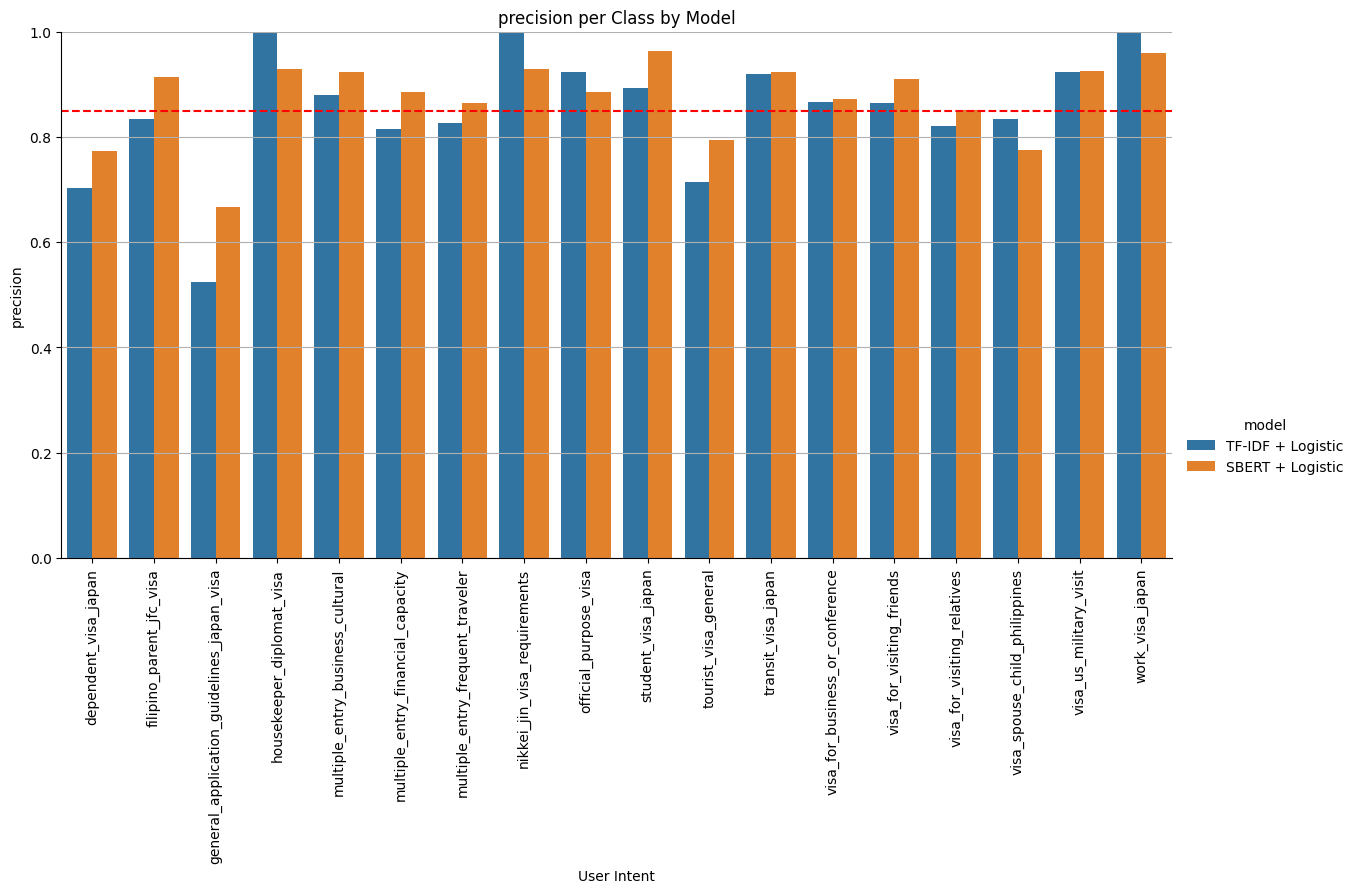

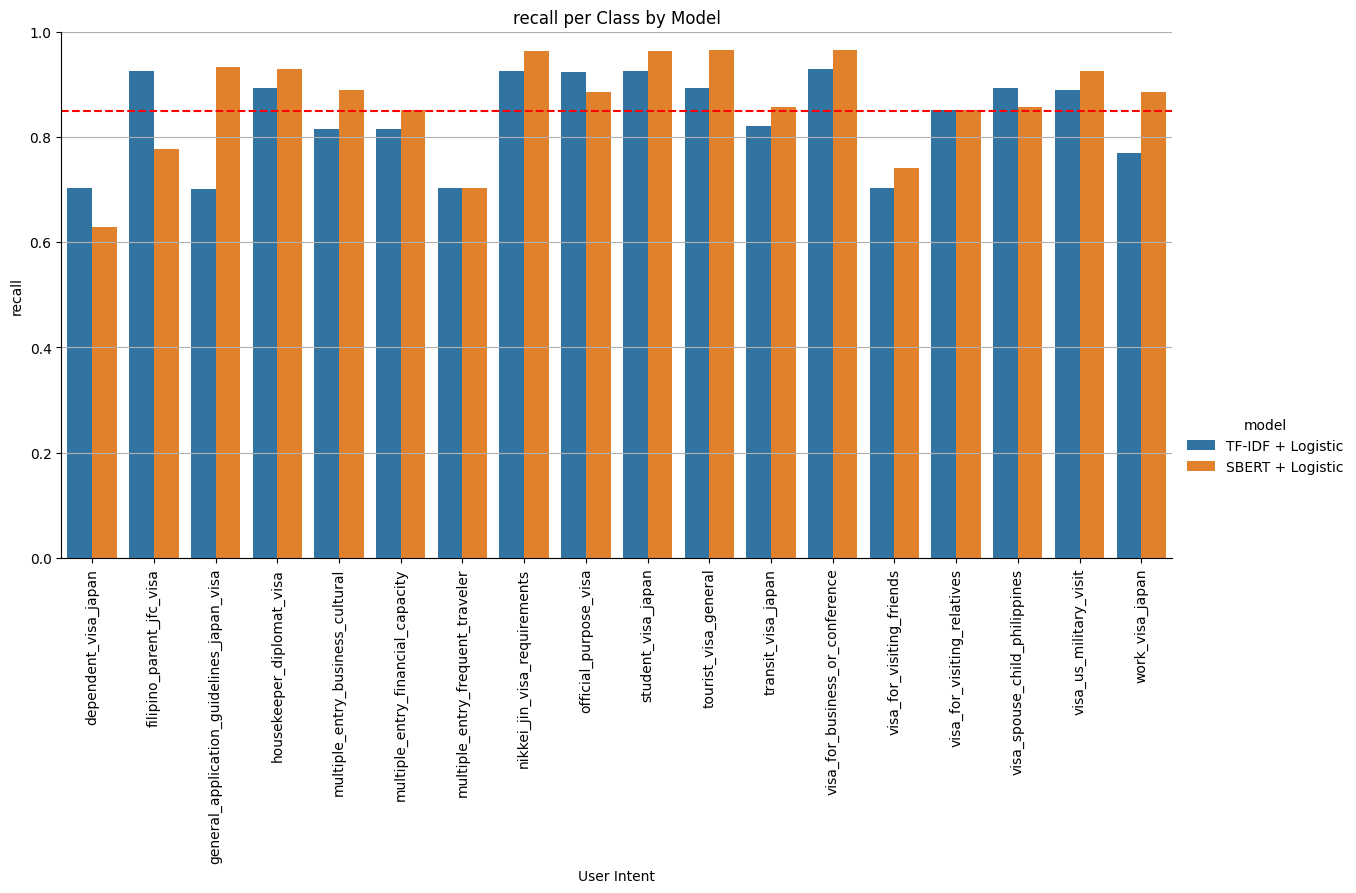

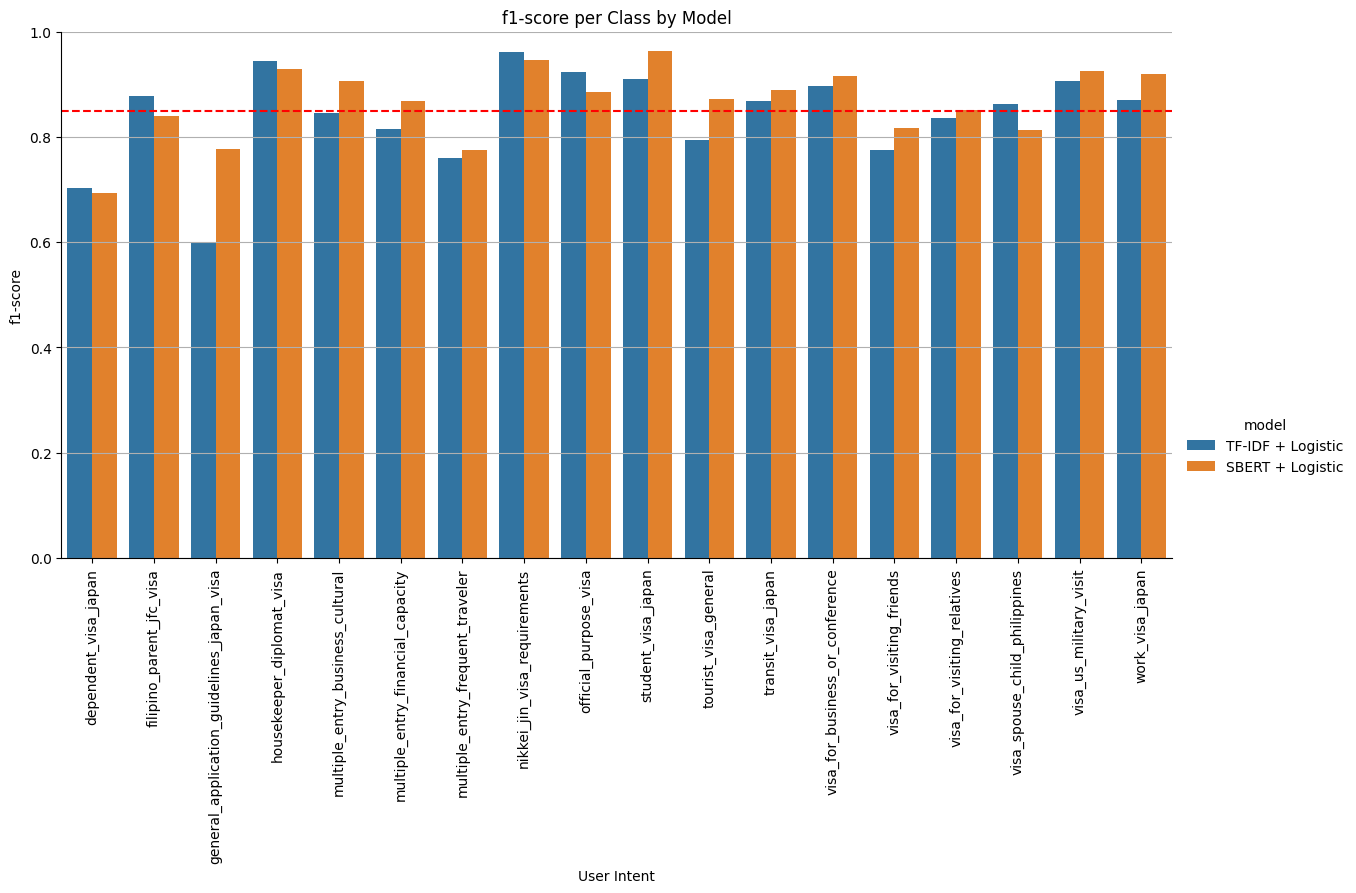

In [171]:
evaluate(random_search_results, X_test, y_test)

### Hyperparameter Tuning for Promising model (Best Model)

In [172]:
best_score = 0
best_idx = -1
for idx, result in enumerate(random_search_results):
    if best_score < result.best_score_:
        best_score = result.best_score_
        best_idx = idx

best_model = random_search_results[best_idx].best_estimator_

In [173]:
best_model

,steps,"[('preprocess', ...), ('embedder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,model_name,'intfloat/multilingual-e5-base'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,7.528477402568786
,fit_intercept,True
,intercept_scaling,1


In [175]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}


grid = GridSearchCV(best_model, param_grid, cv=2, scoring='f1_macro', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


Python(21837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(21838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(21839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke

,estimator,Pipeline(step...7402568786))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2'], 'classifier__solver': ['lbfgs', 'saga']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model_name,'intfloat/multilingual-e5-base'


### Manual Evaluation with 10 questions

In [204]:
questions = [
    "ano ang mga requirments na need i submit for applying japan tourist visa?",
    "gaano katagal ang pag poprocess ng pag-aapply ng japan visa?",
    "gaano katagal ang validity ng japan visa?",
    "kailangan ba na lahat ng i susubmit na documents katulad ng psa ay original documents?",
    "kailangan ba ng parents consent kapag under age ang mag aapply ng visa?",
    "kapag bibisitahin ko ang mga relatives ko sa japan what kind of visa  ang kailangan ko?"
]

for idx, question in enumerate(questions):
    print(f'{question}: {random_search_results[1].predict([question])}')

ano ang mga requirments na need i submit for applying japan tourist visa?: ['general_application_guidelines_japan_visa']
gaano katagal ang pag poprocess ng pag-aapply ng japan visa?: ['work_visa_japan']
gaano katagal ang validity ng japan visa?: ['dependent_visa_japan']
kailangan ba na lahat ng i susubmit na documents katulad ng psa ay original documents?: ['general_application_guidelines_japan_visa']
kailangan ba ng parents consent kapag under age ang mag aapply ng visa?: ['filipino_parent_jfc_visa']
kapag bibisitahin ko ang mga relatives ko sa japan what kind of visa  ang kailangan ko?: ['visa_for_visiting_relatives']


## 💾 Saving a Trained Intent Classifier

```python
import joblib

# 💾 Save model and vectorizer
joblib.dump(model, "intent_model.pkl")
```

In [ ]:
import joblib

# # 💾 Save model and vectorizer
joblib.dump(grid.best_estimator_, "intent_classifier_pipeline.pkl")

['intent_classifier_pipeline.pkl']